## Algorithmic Trading with MachineLearning

### Importing the dataset
In this model, we are going to use daily OHLC data for the stock of “RELIANCE” trading on NSE for the time period from 1st January 1996 to 30 Sep 2018. 

We import our dataset.CSV file named ‘RELIANCE.NS.csv’ saved in the personal drive in your computer. This is done using the pandas library, and the data is stored in a dataframe named dataset. 

We then drop the missing values in the dataset using the dropna() function. We choose only the OHLC data from this dataset, which would also contain the Date, Adjusted Close and Volume data.

In [1]:
#import all libraries
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import Image

In [2]:
# import dataset 
dataset = pd.read_csv('/home/nbuser/library/Module_4_Financial TS Forecasting/RELIANCE.NS.csv', index_col = 0) 
df_stock = dataset.copy()
df_stock = df_stock.dropna()
df_stock = df_stock[['Open', 'High', 'Low', 'Close']]

### Scaling data
Before we split the data set we have to standardize the dataset. This process makes the mean of all the input features equal to zero and also converts their variance to 1. This ensures that there is no bias while training the model due to the different scales of all input features. 

If this is not done the neural network might get confused and give a higher weight to those features which have a higher average value than others. Also, most common activation functions of the network’s neurons such as tanh or sigmoid are defined on the [-1, 1] or [0, 1] interval respectively. 

Nowadays, rectified linear unit (ReLU) activations are commonly used activations which are unbounded on the axis of possible activation values. However, we will scale both the inputs and targets. We will do Scaling using sklearn’s MinMaxScaler.

In [3]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

### Splitting the dataset and Building X & Y
Next, we split the whole dataset into train, valid and test data. 

Then we can build X & Y. So we will get x_train, y_train, x_valid, y_valid, x_test & y_test. This is a crucial part. Please remember we are not simply slicing the data set like the previous project. Here we are giving sequence length as 20.

In [4]:
# Splitting the dataset into Train, Valid & test data 
valid_set_size_percentage = 10 
test_set_size_percentage = 10 
seq_len = 20 # taken sequence length as 20
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() 
    data = [] 
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (4497, 19, 4)
y_train.shape =  (4497, 4)
x_valid.shape =  (562, 19, 4)
y_valid.shape =  (562, 4)
x_test.shape =  (562, 19, 4)
y_test.shape =  (562, 4)


Our total data set is 5640.

So the first 19 data points are x_train.

The next 4497 data points are y_train out of which last 19 data points are x_valid.

The next 562 data points are y_valid out of which last 19 data are x_test.

Finally, the next and last 562 data points are y_test. 

Let's visualize the data points with the table below:

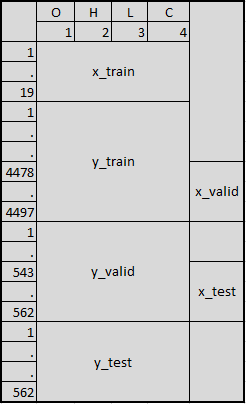

In [5]:
Image('./images/Data-points.png')

### Building the Model
We will build four different models – Basic RNN Cell, Basic LSTM Cell, LSTM Cell with peephole connections and GRU cell. Please remember you can run one model at a time. I am putting everything into one coding. Whenever you run one model, make sure you put the other model as a comment or else your results will be wrong and python might throw an error.

#### Parameters, Placeholders & Variables
We will first fix the Parameters, Placeholders & Variables to building any model. The Artificial Neural Network starts with placeholders. We need two placeholders in order to fit our model: X contains the network’s inputs (features of the stock (OHLC) at time T = t) and Y the network’s output (Price of the stock at T+1). The shape of the placeholders corresponds to None, n_inputs with [None] meaning that the inputs are a 2-dimensional matrix and the outputs are a 1-dimensional vector. It is crucial to understand which input and output dimensions the neural net needs in order to design it properly. 

We define the variable batch size as 50 that controls the number of observations per training batch. We stop the training network when epoch reaches 100 as we have given epoch as 100 in our parameter.

In [6]:
## Building the Model
# parameters & Placeholders 
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

### Designing the network architecture
Before we proceed, we have to write the function to run the next batch for any model. Then we will write the layers for each model separately.

In [7]:
# function to get the next batch
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size 
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size     
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

Please remember you need to put the other models as a comment whenever you running one particular model. Here we are running only RNN basic so I kept all others as a comment. You can run one model after another.

In [8]:
#RNN 
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
# LSTM  
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#        for layer in range(n_layers)]

#LSTM with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

#GRU 
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)] 
                                                                  
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


### Cost function
We use cost function to optimize the model. The cost function is used to generate a measure of deviation between the network’s predictions and the actual observed training targets. For regression problems, the mean squared error (MSE) function is commonly used. MSE computes the average squared deviation between predictions and targets.

In [9]:
# Cost function
loss = tf.reduce_mean(tf.square(outputs - y))

### Optimizer
The optimizer takes care of the necessary computations that are used to adapt the network’s weight and bias variables during training. Those computations invoke the calculation of gradients that indicate the direction in which the weights and biases have to be changed during training in order to minimize the network’s cost function. The development of stable and speedy optimizers is a major field in neural network and deep learning research.

In [10]:
#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

In this model we use Adam (Adaptive Moment Estimation) Optimizer, which is an extension of the stochastic gradient descent, is one of the default optimizers in deep learning development.

### Fitting the neural network model & prediction
Now we need to fit the model that we have created to our train datasets. After having defined the placeholders, variables, initializers, cost functions and optimizers of the network, the model needs to be trained. Usually, this is done by mini batch training. During mini batch training random data samples of n = batch_size are drawn from the training data and fed into the network.

The training dataset gets divided into n / batch_size batches that are sequentially fed into the network. At this point the placeholders X and Y come into play. They store the input and target data and present them to the network as inputs and targets.

A sampled data batch of X flows through the network until it reaches the output layer. There, TensorFlow compares the model’s predictions against the actual observed targets Y in the current batch. Afterwards, TensorFlow conducts an optimization step and updates the network parameters, corresponding to the selected learning scheme. After having updated the weights and biases, the next batch is sampled and the process repeats itself.

The procedure continues until all batches have been presented to the network. One full sweep over all batches is called an epoch.

The training of the network stops once the maximum number of epochs is reached or another stopping criterion defined by the user applies. We stop the training network when epoch reaches 100 as we have given epoch as 100 in our parameter.

In [11]:
# Fitting the model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
# Predictions
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})


0.00 epochs: MSE train/valid = 0.037400/0.089763
4.99 epochs: MSE train/valid = 0.000092/0.000120
9.98 epochs: MSE train/valid = 0.000067/0.000071
14.98 epochs: MSE train/valid = 0.000057/0.000052
19.97 epochs: MSE train/valid = 0.000050/0.000041
24.96 epochs: MSE train/valid = 0.000070/0.000096
29.95 epochs: MSE train/valid = 0.000047/0.000037
34.95 epochs: MSE train/valid = 0.000064/0.000080
39.94 epochs: MSE train/valid = 0.000052/0.000050
44.93 epochs: MSE train/valid = 0.000040/0.000030
49.92 epochs: MSE train/valid = 0.000065/0.000081
54.91 epochs: MSE train/valid = 0.000041/0.000031
59.91 epochs: MSE train/valid = 0.000038/0.000025
64.90 epochs: MSE train/valid = 0.000089/0.000139
69.89 epochs: MSE train/valid = 0.000057/0.000070
74.88 epochs: MSE train/valid = 0.000072/0.000111
79.88 epochs: MSE train/valid = 0.000046/0.000043
84.87 epochs: MSE train/valid = 0.000076/0.000118
89.86 epochs: MSE train/valid = 0.000053/0.000059
94.85 epochs: MSE train/valid = 0.000067/0.000088
99.

Now we have predicted the stock prices and saved as y_test_pred. We can compare these predicted stock prices with our target stock prices which is y_test. Just to check no of output, I run the below code and its 562 which is matching with y_test data.

In [12]:
#checking prediction output nos 
y_test_pred.shape

(562, 4)

Let’s compare between our target and prediction. I put both target (y_test) & prediction (y_test_pred) closing price in one data frame named as “comp”. Now I put both prices in one graph, let see how it looks.

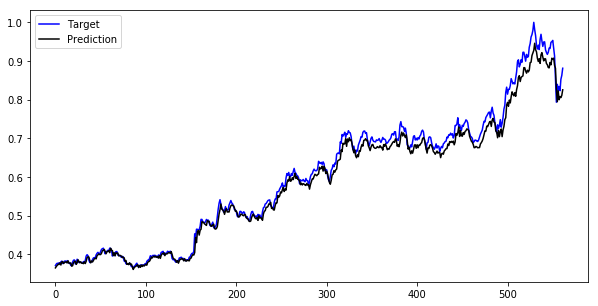

In [13]:
# ploting the graph
comp = pd.DataFrame({'Column1':y_test[:,3],'Column2':y_test_pred[:,3]})
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column2'], color='black', label='Prediction')
plt.legend()
plt.show()

Now we can see, the results are not bad. The prediction values are exactly the same as the target value and moving in the same direction as we expect. You can check the difference between these two and compare the results in various ways & optimize the model before you build your trading strategy.

### LSTM
Now we can run the Basic LSTM model and see the results

In [14]:
# LSTM  
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
       for layer in range(n_layers)]

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


### LSTM with peephole
Let’s run the LSTM with peephole connections model and see the results

In [15]:
#LSTM with peephole connections
layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
                                 activation=tf.nn.leaky_relu, use_peepholes = True)
         for layer in range(n_layers)]

### GRU
Let’s run the GRU model and see the results

In [16]:
#GRU 
layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
         for layer in range(n_layers)] 

You can check and compare the results in various ways & optimize the model before you building your trading strategy.

### Conclusion
The objective of this project is to make you understand how to build different neural network model like RNN, LSTM & GRU in python tensor flow and predicting stock price. You can optimize this model in various ways and build your own trading strategy to get a good strategy return considering Hit Ratio, draw down etc.

Another important factor, we have used daily prices in this model so the data points are really less only 5,640 data points. My advice is to use more than 100,000 data points (use minute or tick data) for training the model when you are building Artificial Neural Network or any other Deep Learning model that will be most effective.

Now you can build your own trading strategy using the power and intelligence of your machines.